## import the libraries 

In [1]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


### Function to return pandas dataframe from root file 

In [2]:
def get_pandasDataFrame(process,path,fileName,treeName,branches,selection):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Process'] = process
    print(type(pd_dataframe))
    return pd_dataframe

## Flattened root input files for signal and backgrounds with 

In [3]:
branches=['scE',
          'scEt',
          'scEta',
          'scPhi',
          'scEtaWidth',
          'scMinDrWithGsfElectornSC_',
          'scFoundGsfMatch_',
          'scR9',
          'scSigmaIetaIeta',
          'scSigmaIetaIphi',
          'scEMaxRatio',
          'scSwissCross',
          'scE2x5_MaxRatio',
          'scE2ndRatio' ,       
          'scPFPhoIso1',
          'scPFPhoIso2',
          'scPFPhoIso3',
          'scPFPhoIso4',
          'scPFPhoIso5',
          'scPFChIso1',
          'scPFChIso2',
          'scPFChIso3',
          'scPFChIso4',
          'scPFChIso5'          
         ]


In [4]:
start = time.time()

qcd_df=get_pandasDataFrame("QCD","/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/",
                           "mc_qcd20To30EmEnriched_barrel.root",
                           "mergedPi0_SCTree",branches=branches,selection="(scEt>4) & (scEt<15)")

pi0_df=get_pandasDataFrame("Flat_pi0","/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/",
                           "mc_bkg_flat_pi0_barrel.root",
                           "mergedPi0_SCTree",branches=branches,selection="(scEt>4) & (scEt<15)")

data_df=get_pandasDataFrame("data","/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/",
                            "data_2018D_barrel.root",
                            "dataAllSCTree",branches=branches,selection="(scEt>4) & (scEt<15)")

bkg_df = pd.concat([qcd_df,pi0_df,data_df])
end  = time.time()
print("Execution time is", end-start)

(scEt>4) & (scEt<15)
<class 'pandas.core.frame.DataFrame'>
(scEt>4) & (scEt<15)
<class 'pandas.core.frame.DataFrame'>
(scEt>4) & (scEt<15)
<class 'pandas.core.frame.DataFrame'>
Execution time is 14.225342035293579


In [5]:
print("QCD numbner of rows: ", qcd_df.shape)
print("pi0 numbner of rows: ", pi0_df.shape)
print("Data numbner of rows: ", data_df.shape)

QCD numbner of rows:  (70660, 25)
pi0 numbner of rows:  (51097, 25)
Data numbner of rows:  (586780, 25)


## Shuffle the background dataframe 

In [6]:
from sklearn.utils import shuffle
bkg_df = shuffle(bkg_df)

In [7]:
#bkg_df.head()

### Define signal input

In [8]:
processes = {'signal':{'path':'/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/',
                 'fileName':'mc_signal_bsMMG_barrel.root',
                 'treeName':'genMatchedBMMGSCTree'}
            }

### Append pandas dataframe to dask framework using delayed to reduce the computing time

In [9]:
dfs= []
start = time.time()
for process in processes:
    path = processes[process]['path']
    fileName = processes[process]['fileName']
    treeName = processes[process]['treeName']
    #print(path,fileName,treeName)
    dfs.append(delayed(get_pandasDataFrame(process,path,fileName,treeName,branches=branches,selection='abs(scEta)<1.4442 & (scEt>4) & (scEt<15)')))
    #dfs.append(delayed(get_pandasDataFrame(process,path,fileName,treeName,branches=branches,selection='abs(scEta)>1.4442 & abs(scEta)<2.4 & (scEt>4) & (scEt<15)')))
end  = time.time()
print("Execution time is", end-start)


abs(scEta)<1.4442 & (scEt>4) & (scEt<15)
<class 'pandas.core.frame.DataFrame'>
Execution time is 8.047197103500366


In [10]:
dfs.append(delayed(bkg_df))

In [11]:
#dfs

In [12]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)

In [13]:
#final_df.head()

## Prepare the dataframe for reweighting and finding weights  

In [14]:
final_df['Category']=final_df['Process'].map({'signal':0,'data':1,'QCD':1,"Flat_pi0":1})
final_df['Class']=final_df['Process'].map({'signal':'signal','data':'bkg','QCD':'bkg',"Flat_pi0":'bkg'})
final_df["NewWt"]=1
final_df["xsecwt"]=1


In [15]:
#final_df.head()

In [16]:
Classes = ['signal','bkg']

## Divide the dataframe for training and testing
adapted from LPC Egamma ID tutorial

In [17]:
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.2, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [18]:
#final_df.head()

Text(0.5, 1.0, 'Number of samples')

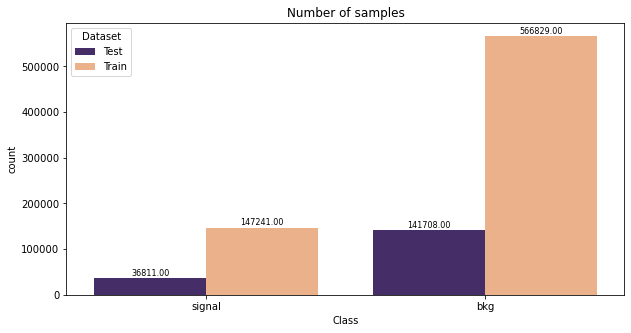

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [20]:
#final_df['Category'].unique()

In [21]:
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))


def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",OutputDirName='Figures',cat='Category',label=[""],weight="NewWt",log=False):
    #fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
    fig, axes = plt.subplots(1, 1, figsize=(len(features)*5, 5))

    prGreen("Making "+Set+" dataset spectator plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            print(m, i)
            group_df[features[m]].hist(histtype='step', bins=feature_bins[m], alpha=1,label=label[i], ax=axes, density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=2)
        axes.legend(loc='best')
        axes.set_xlabel(features[m])
        if log:
            axes.set_yscale("log")
            axes.set_ylim([0.0001,1])
        axes.set_title(features[m]+" ("+Set+" Dataset)")
        plt.savefig(OutputDirName+'/'+features[m]+Set+".png".format(m))




 Making Train dataset spectator plots
0 0
0 1
1 0
1 1


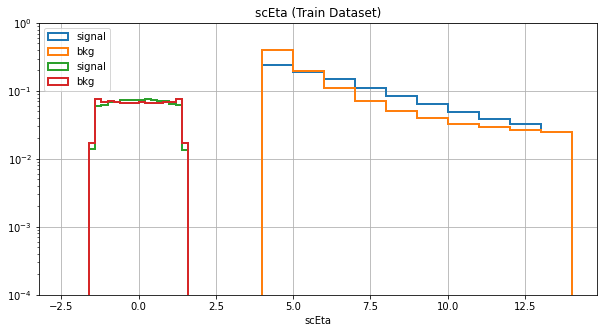

In [22]:
Variables=['scEt','scEta']
VarBins=[MyBins(0,15,1), MyBins(-2.4,2.4,0.2)]
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


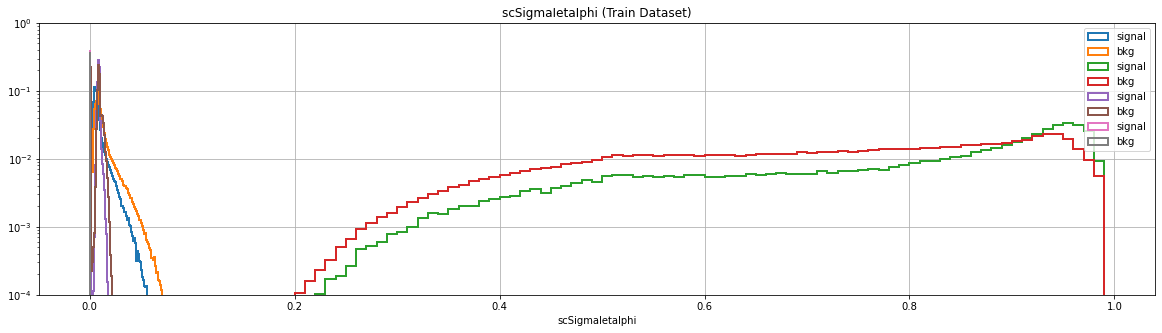

In [23]:
ShowerShape_widths=['scEtaWidth',
          'scR9',
          'scSigmaIetaIeta',
          'scSigmaIetaIphi']
VarBins=[MyBins(0,0.1,0.001), 
        MyBins(0,1,0.01), 
        MyBins(0,0.1,0.001),
        MyBins(0,0.002,0.00001)]
MakeFeaturePlots(final_df,ShowerShape_widths,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


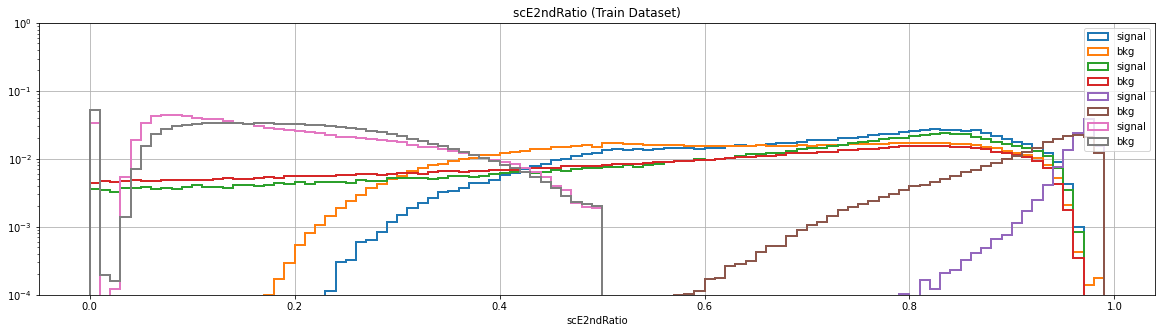

In [24]:
ShowerShape_Ratios=['scEMaxRatio',
          'scSwissCross',
          'scE2x5_MaxRatio',
          'scE2ndRatio']
VarBins=[MyBins(0,1,0.01)]*len(ShowerShape_Ratios)
MakeFeaturePlots(final_df,ShowerShape_Ratios,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1


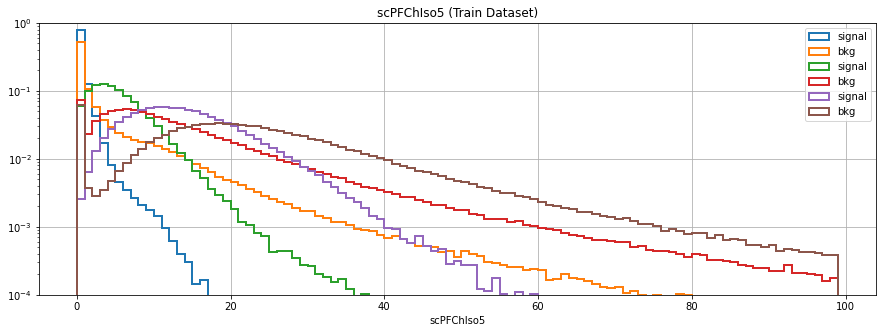

In [25]:
isolation_vars=['scPFChIso1','scPFChIso3','scPFChIso5']
VarBins=[MyBins(0,100,1)]*len(isolation_vars)
MakeFeaturePlots(final_df,isolation_vars,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

## Reweighting 

In [26]:
import Tools.ptetaRwt as ptetaRwt

In [27]:
final_df.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TrainIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="signal",Classes=Classes)

final_df.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TestIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="signal",Classes=Classes)

Number of xsec events in bkg for pt 4 to 6 before  weighing = 43325
Number of xsec events in signal for pt 4 to 6 before  weighing = 6177
Number of xsec events in bkg for pt 6 to 8 before  weighing = 12845
Number of xsec events in signal for pt 6 to 8 before  weighing = 4126
Number of xsec events in bkg for pt 8 to 10 before  weighing = 6001
Number of xsec events in signal for pt 8 to 10 before  weighing = 2346
Number of xsec events in bkg for pt 10 to 13 before  weighing = 5913
Number of xsec events in signal for pt 10 to 13 before  weighing = 1968
Number of xsec events in bkg for pt 13 to 15 before  weighing = 3225
Number of xsec events in signal for pt 13 to 15 before  weighing = 795
Number of xsec events in bkg for pt 4 to 6 before  weighing = 35099
Number of xsec events in signal for pt 4 to 6 before  weighing = 6372
Number of xsec events in bkg for pt 6 to 8 before  weighing = 10932
Number of xsec events in signal for pt 6 to 8 before  weighing = 3779
Number of xsec events in bkg

Number of xsec events in bkg for pt 4 to 6 before  weighing = 13833
Number of xsec events in signal for pt 4 to 6 before  weighing = 3007
Number of xsec events in bkg for pt 6 to 8 before  weighing = 4240
Number of xsec events in signal for pt 6 to 8 before  weighing = 1758
Number of xsec events in bkg for pt 8 to 10 before  weighing = 2293
Number of xsec events in signal for pt 8 to 10 before  weighing = 1067
Number of xsec events in bkg for pt 10 to 13 before  weighing = 2231
Number of xsec events in signal for pt 10 to 13 before  weighing = 786
Number of xsec events in bkg for pt 13 to 15 before  weighing = 1204
Number of xsec events in signal for pt 13 to 15 before  weighing = 291
Number of xsec events in bkg for pt 4 to 6 before  weighing = 8518
Number of xsec events in signal for pt 4 to 6 before  weighing = 1697
Number of xsec events in bkg for pt 6 to 8 before  weighing = 2654
Number of xsec events in signal for pt 6 to 8 before  weighing = 1034
Number of xsec events in bkg for

In [28]:
final_df['NewWt'].unique()

array([1.        , 0.21509379, 0.18154363, 0.20283633, 0.14257357,
       0.37933607, 0.21976593, 0.1764773 , 0.14486197, 0.19882011,
       0.40639671, 0.37028986, 0.38770227, 0.34138404, 0.2156188 ,
       0.4190424 , 0.18520036, 0.14923157, 0.35999247, 0.3332302 ,
       0.37238915, 0.19922517, 0.23616846, 0.18226428, 0.31346543,
       0.2421395 , 0.46532926, 0.23305381, 0.22957198, 0.39970972,
       0.41462264, 0.34528449, 0.45888864, 0.23679608, 0.40261866,
       0.32121448, 0.3896006 , 0.35544332, 0.42118675, 0.36052871,
       0.4709758 , 0.21737873, 0.14403587, 0.35047361, 0.38771593,
       0.2449692 , 0.19952381, 0.25162372, 0.39582388, 0.39093484,
       0.40224899, 0.46956522, 0.42920269, 0.36218679, 0.35230838,
       0.36212505, 0.24169435, 0.35011228, 0.34562212, 0.3456824 ,
       0.34355375, 0.35673352, 0.21336409, 0.24651163, 0.44217687,
       0.4317315 , 0.23481528, 0.33282598, 0.35281797, 0.35281837,
       0.43208911, 0.22171254, 0.37110266, 0.23673469, 0.41197

Text(0.5, 1.0, 'Number of samples')

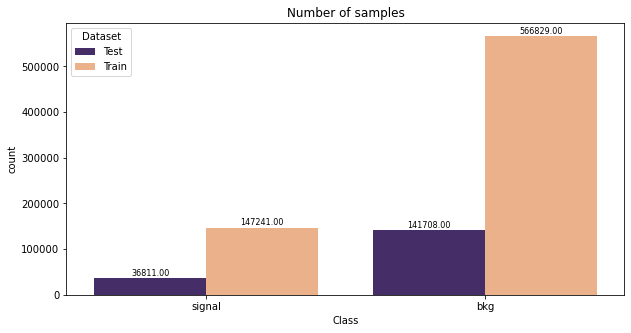

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [30]:
final_df.head(5)

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Process,Category,Class,NewWt,xsecwt,Dataset,TrainDataset
0,7.753203,6.792725,0.525711,1.196866,0.003998,1.000000e+09,0.0,0.658708,0.009202,0.000000e+00,0.915197,0.907339,1.000000,0.084803,6.091204,6.091204,6.091204,6.091204,6.091204,0.000000,3.246895,3.246895,4.601000,8.016312,signal,0,signal,1.0,1,Test,0.0
1,10.727509,10.485172,-0.214587,-2.308056,0.008042,1.000000e+09,0.0,1.000000,0.008907,8.288317e-07,0.393128,-0.279215,1.000000,0.293671,0.000000,0.332892,1.092775,1.092775,2.232820,0.000000,0.623293,2.910528,6.503263,7.525467,signal,0,signal,1.0,1,Train,1.0
2,9.719466,9.167964,-0.345143,-1.720641,0.004737,1.000000e+09,0.0,1.000000,0.009747,1.701725e-06,0.889623,0.875929,0.974408,0.049591,0.000000,0.640867,2.352639,2.352639,3.793797,0.000000,2.969234,4.879227,12.608646,17.172276,signal,0,signal,1.0,1,Train,1.0
3,8.638324,8.251705,0.304932,-1.335767,0.004465,2.583050e+00,0.0,1.000000,0.008106,-7.329957e-06,0.876202,0.858711,1.000000,0.071302,7.805819,7.805819,7.805819,7.805819,10.001609,0.329437,0.329437,2.909377,4.027423,5.611387,signal,0,signal,1.0,1,Train,1.0
4,7.175752,6.075890,-0.592973,0.308302,0.004411,1.000000e+09,0.0,0.947147,0.000000,0.000000e+00,0.590617,0.306855,1.000000,0.409383,5.758420,5.758420,6.070301,6.887314,7.134089,1.194138,1.478183,2.034288,3.374829,4.842720,signal,0,signal,1.0,1,Train,1.0


 Making Train dataset spectator plots
0 0
0 1
1 0
1 1


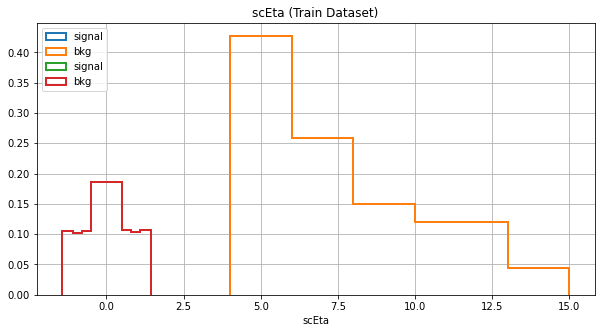

In [31]:
Variables=['scEt','scEta']
#VarBins=[[4,6,8,10,13,15], [-2.4,-2.0,-1.566,1.566,2.0,2.4]]
VarBins=[[4,6,8,10,13,15],[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]]
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=False)

## Define MVA parameters as a dictionary 

In [32]:
import pickle
import multiprocessing
import seaborn as sns

In [33]:
OutputDirName="Output_barrel"
os.system("mkdir -p "+OutputDirName)

0

In [34]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

os.system("mkdir -p " + OutputDirName+"/"+MVA["MVAtype"])

0

In [35]:
def corre(df,Classes=[''],MVA={}):
    for C in Classes:
            for k in ["Train","Test"]:
                fig, axes = plt.subplots(1, 1, figsize=(len(MVA["features"]), len(MVA["features"])))
                cor = df.loc[(df['Dataset'] == k) & (df['Class'] == str(C))][MVA["features"]].corr()
                sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=axes,annot_kws={"size":len(MVA["features"])/4})
                axes.tick_params(axis='x', labelsize=len(MVA["features"]))
                axes.tick_params(axis='y', labelsize=len(MVA["features"]))
                
                fig.savefig(OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".png")

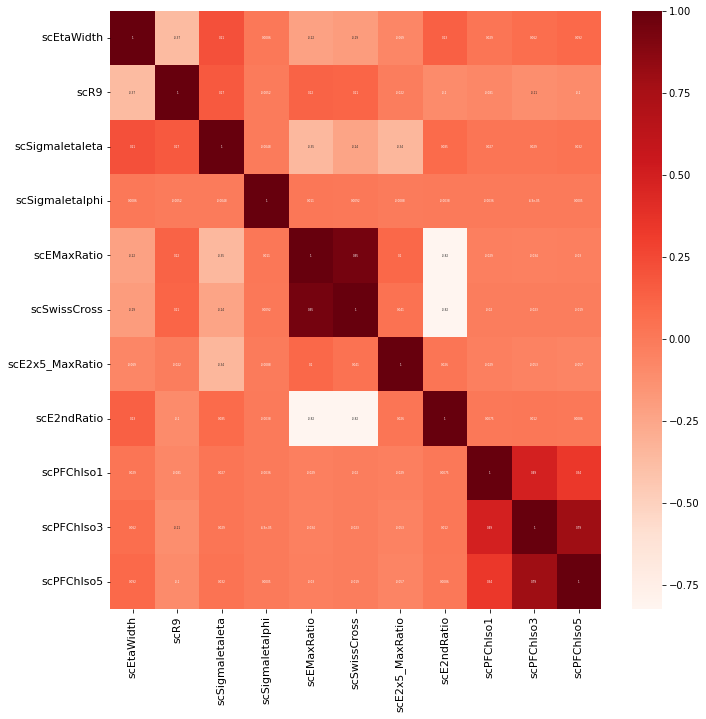

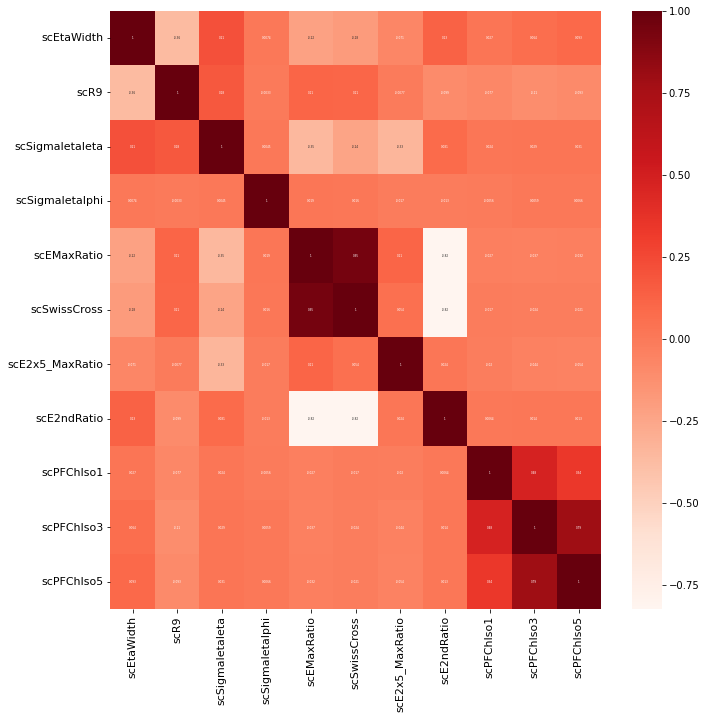

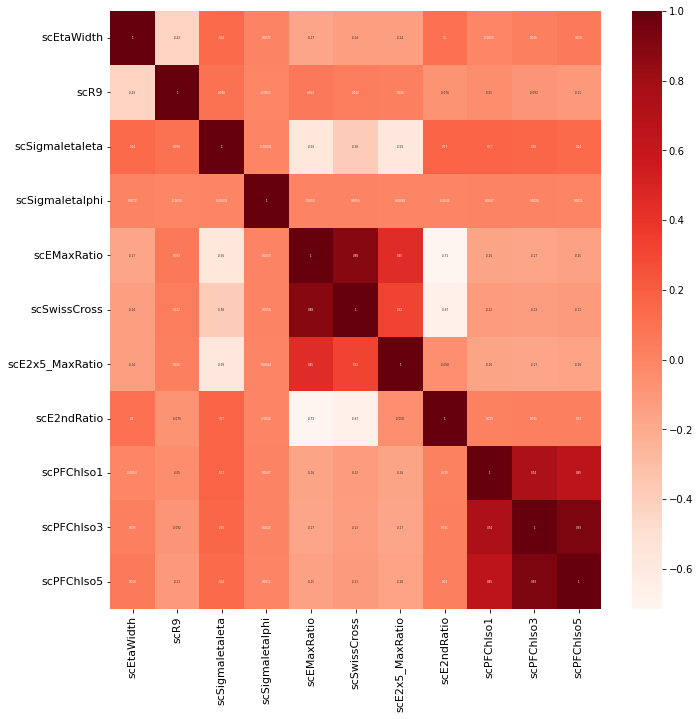

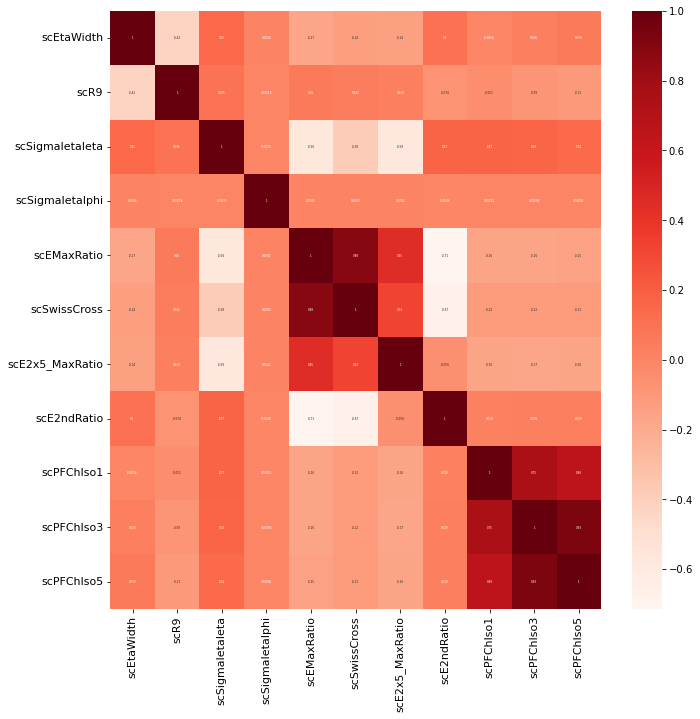

In [36]:
corre(final_df,Classes,MVA)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1
5 0
5 1
6 0
6 1
7 0
7 1
8 0
8 1
9 0
9 1
10 0
10 1


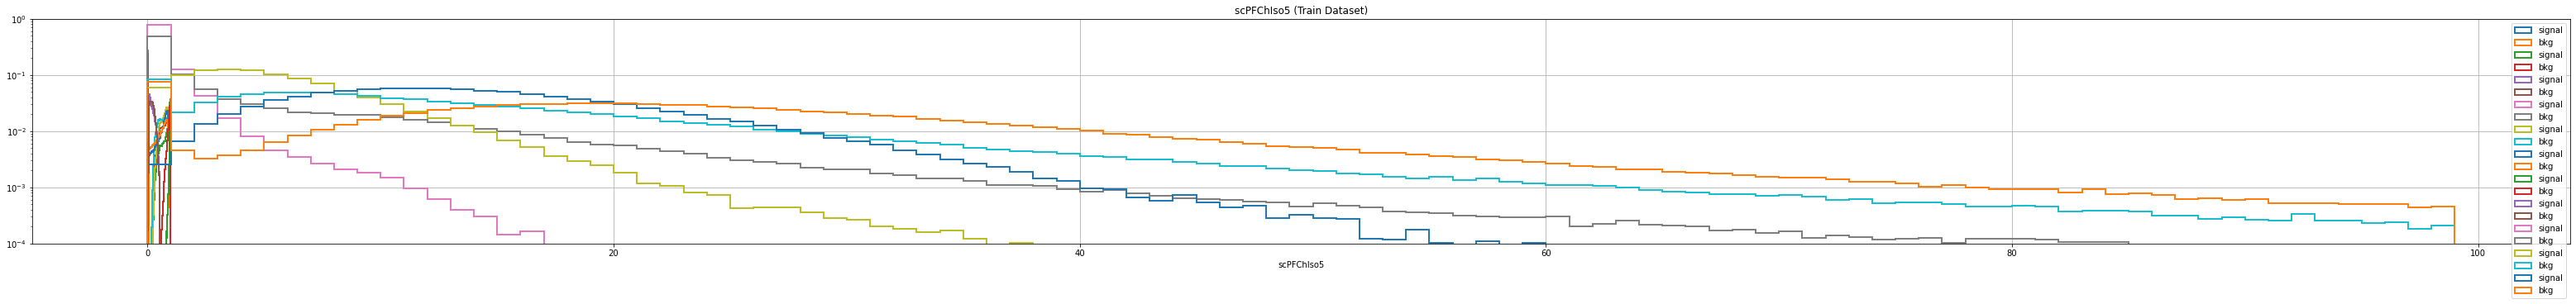

In [37]:
MakeFeaturePlots(final_df,MVA["features"],MVA["feature_bins"],Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

## Data preparation 

In [38]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

## XGBoost training

In [39]:
'''
def runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):
    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
    exec("from sklearn.preprocessing import "+MVA["Scaler"])
    exec("sc = "+MVA["Scaler"]+"()")
    #scale the training data input features so that it is between 0 and 1
    X_train = Scaler.fit_transform(X_train) 
    X_test = Scaler.transform(X_test)
    
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    eval_s = [(X_train, Y_train),(X_test,Y_test)]
    if "UseGPU" in MVA and MVA["UseGPU"]:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
    else:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)
    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
    prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
    prGreen("XGB Best Parameters")
    prGreen(str(search.best_params_))
    fig, ax = plt.subplots()
    ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
    ax.set_xlabel("Xgboost Feature Importance")
    
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test,cv, search
'''

'\ndef runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):\n    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)\n    exec("from sklearn.preprocessing import "+MVA["Scaler"])\n    exec("sc = "+MVA["Scaler"]+"()")\n    #scale the training data input features so that it is between 0 and 1\n    X_train = Scaler.fit_transform(X_train) \n    X_test = Scaler.transform(X_test)\n    \n    import xgboost as xgb\n    from sklearn.model_selection import cross_val_score, GridSearchCV\n    eval_s = [(X_train, Y_train),(X_test,Y_test)]\n    if "UseGPU" in MVA and MVA["UseGPU"]:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= \'gpu_hist\',random_state=42)\n    else:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)\n    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring=\'neg_log_loss\',cv=3,verbose=1)\n    search=cv.fit(

## Run the training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Expected neg log loss of XGB model = -48.0%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
Execution time is 963.8511364459991


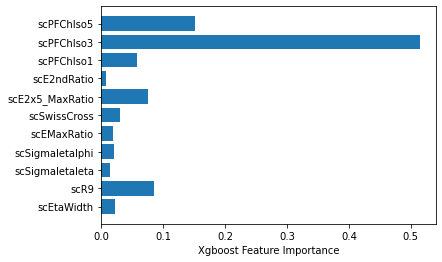

In [40]:
start = time.time()

exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")

X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)
    
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
eval_s = [(X_train, Y_train),(X_test,Y_test)]

#if "UseGPU" in MVA and MVA["UseGPU"]:
 #   xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
#else:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)

cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
prGreen("XGB Best Parameters")
prGreen(str(search.best_params_))
fig, ax = plt.subplots()
ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
ax.set_xlabel("Xgboost Feature Importance")

#X_train, Y_train, Wt_train, X_test, Y_test, Wt_test, cv, search=runXGBTraining(final_df,TrainIndices,TestIndices,MVA,sc,cat='Category',weight="NewWt")

end = time.time()
print("Execution time is", end-start)

In [41]:
type(search)

sklearn.model_selection._search.GridSearchCV

In [42]:
type(xgb_model)

xgboost.sklearn.XGBClassifier

In [43]:
#from xgboost import plot_tree
#plot_tree(booster=search,trees=1)
#plt.show()

## Diagnostic error plot 

Text(0.5, 1.0, 'XGB small list XGBoost Error')

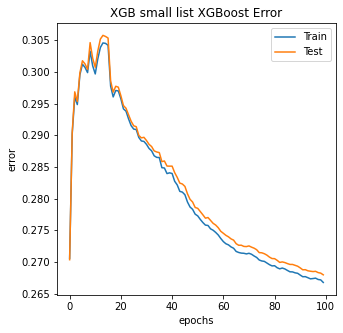

In [44]:
results = cv.best_estimator_.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [45]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

2022-09-01 18:12:37.855381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [46]:
final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [47]:
plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

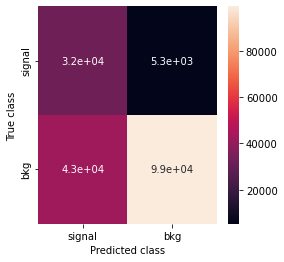

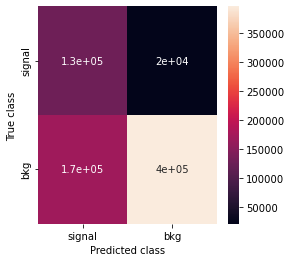

In [48]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

In [49]:
ClassColors =['#377eb8', '#ff7f00']

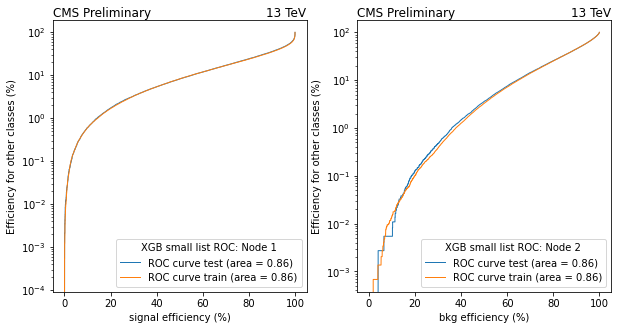

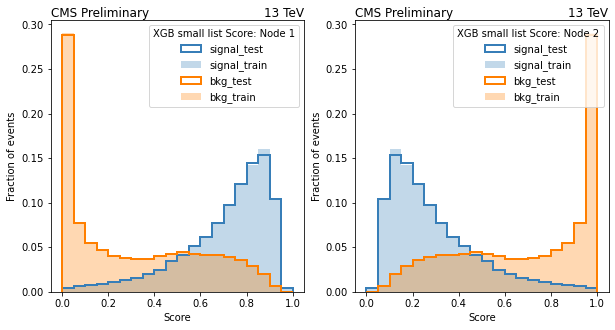

In [50]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

## Advanced exercise 

In [51]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [52]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [53]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptwtvar='scEt'
etawtvar='scEta'

In [54]:
cat='Category'

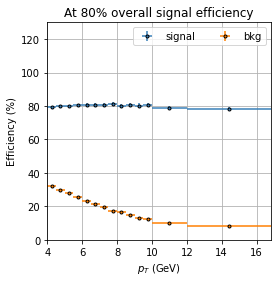

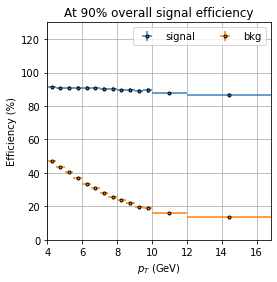

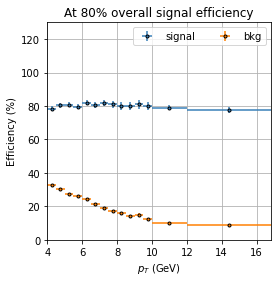

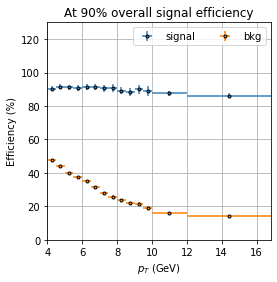

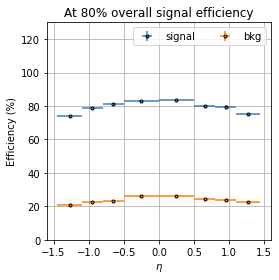

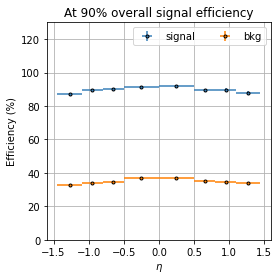

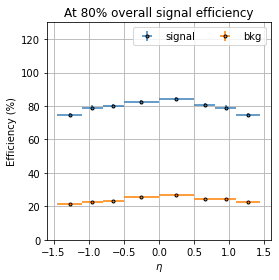

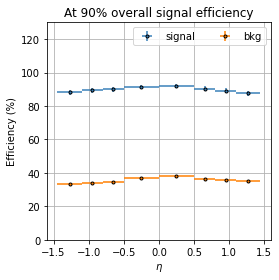

In [55]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)